In [18]:
import pdfplumber as pdfp
import os
import regex as re

files = os.listdir(r"C:\Users\there\Documents\Code\Numismatics\OCR\pdfs\simple")
pre = r"C:\Users\there\Documents\Code\Numismatics\OCR\pdfs\simple\\"
settings = {
    "vertical_strategy": "lines", # text 
    "horizontal_strategy": "lines", 
    "explicit_vertical_lines": [],
    "explicit_horizontal_lines": [],
    "snap_tolerance": 3,
    "snap_x_tolerance": 3,
    "snap_y_tolerance": 3,
    "join_tolerance": 3,
    "join_x_tolerance": 3,
    "join_y_tolerance": 3,
    "edge_min_length": 3,
    "min_words_vertical": 3,
    "min_words_horizontal": 1,
    "intersection_tolerance": 3,
    "intersection_x_tolerance": 600,
    "intersection_y_tolerance": 600,
    "text_tolerance": 3,
    "text_x_tolerance": 3,
    "text_y_tolerance": 3,
}

In [19]:
def is_separator(row):
    index = row[0]
    if (index is None or len(index) == 0 or len(index) >= 5 or not any(char.isdigit() for char in index) 
    or sum(1 for col in row if (col == "" or col == " " or col == None)) >= len(row) / 2):
        return True
    return False

In [20]:
def is_header(row, labels):
    return row[0] == labels[0]

In [21]:
def get_separator(original_row, page):
    tables = page.find_tables(settings)
    for table in tables:
        i = 0
        rows = table.extract()
        
        for row in rows:
            if row == original_row:
                bbox = table.rows[i].cells
                xL = bbox[0][0]
                xR = bbox[len(bbox)-1][2]
                down = bbox[0][1]
                up = bbox[0][3]
                bbox = (xL, down, xR, up)
                break
            i += 1
    
    croppedPage = page.crop(bbox)

    return croppedPage.extract_text()

In [22]:
def getLabels(path): 
    labels = []
    pages = pdfp.open(path).pages
    for page in pages:
        labels = page.extract_tables()
        if len(labels) > 0:
            labelsDict = {}
            labels = labels[0][0]
            for i, label in enumerate(labels):
                labelsDict[i] = label
            return labelsDict
    return {}

In [23]:
def run(mapping, grouping, grouping_label, path):
    coins = []
    pdf = pdfp.open(path)
    labels = getLabels(path)
    i = 1
    print(f"Extracting {path}")
    for page in pdf.pages:
        print(f"On page {i}")
        i += 1
        tables = page.extract_tables(table_settings=settings)
        for table in tables:
            print("In Table")
            for row in table:
                print("Row")

                if len(row) != len(labels) or any(col == None for col in row):
                    print("Quit 1")
                    continue

                if is_separator(row):
                    if is_header(row, labels):
                        # print("WAS HEADER")
                        continue
                    grouping = get_separator(row, page)
                    continue
                
                coin = {}
                for key, label in labels.items():
                    coin[label] = row[key]
                coin[grouping_label] = grouping
                coins.append(coin)

    dataPath = r"C:\Users\there\Documents\Code\Numismatics\OCR\data\\" + re.search(r'[^\\]+$', path).group(0) + r".txt"
    with open(dataPath, "w", encoding="utf-8") as f:
        for coin in coins:
            f.write(f"{coin}\n")

labels = {0: "ID", 1: "weight", 2: "Start_Year", 3: "Name", 4: "reference", 5: "notes"}
# for file in files:
#     run(labels, None, "Ruler", pre+file)
run(labels, None, "Ruler", pre+"crop.pdf")

Extracting C:\Users\there\Documents\Code\Numismatics\OCR\pdfs\simple\\crop.pdf
On page 1


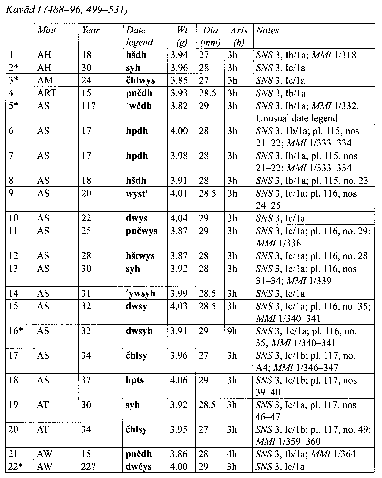

In [24]:
path = r"C:\Users\there\Documents\Code\Numismatics\OCR\pdfs\simple\crop.pdf"
pdf = pdfp.open(path)

p6 = pdf.pages[0]
im = p6.to_image()
im

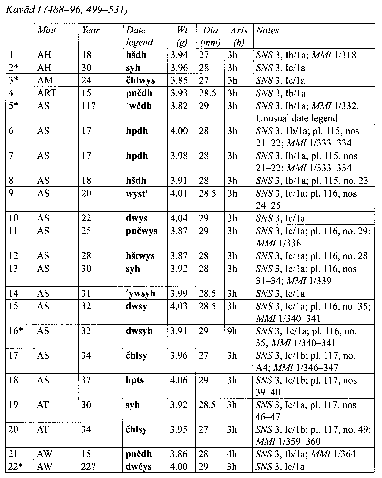

In [25]:
num = 30000 # default: 3
settings = {
    "vertical_strategy": "lines", # text 
    "horizontal_strategy": "lines", 
    "explicit_vertical_lines": [],
    "explicit_horizontal_lines": [],
    "snap_tolerance": num,
    "snap_x_tolerance": num,
    "snap_y_tolerance": num,
    "join_tolerance": num,
    "join_x_tolerance": num,
    "join_y_tolerance": num,
    "edge_min_length": num,
    "min_words_vertical": 0,
    "min_words_horizontal": 0,
    "intersection_tolerance": num,
    "intersection_x_tolerance": 6000,
    "intersection_y_tolerance": 6000,
    "text_tolerance": num,
    "text_x_tolerance": num,
    "text_y_tolerance": num,
}

im.reset().debug_tablefinder(settings)

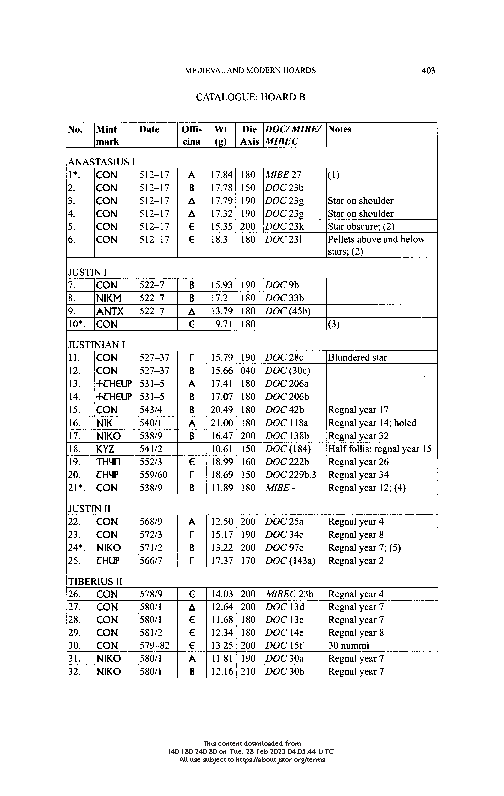

In [26]:
path = r"C:\Users\there\Documents\Code\Numismatics\OCR\pdfs\simple\Mansfield, S.J. “Byzantine Hoards- Lebanon or Syria.” Royal Numismatic Society, Numismatic Chronicle, 173, 2013, 391–413..pdf"
pdf = pdfp.open(path)

p2 = pdf.pages[2]
im = p2.to_image()
im

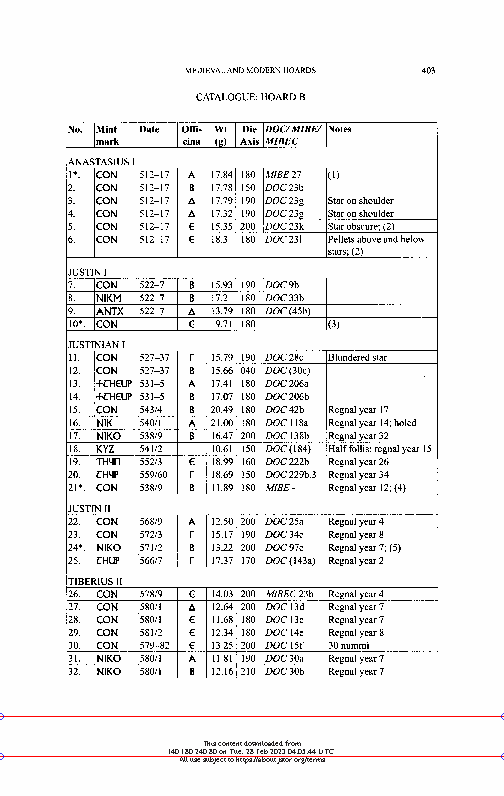

In [27]:
im.reset().debug_tablefinder()